**Done By VISHVESHWARA**

---


**Register Number: 21BAI1208**

In [1]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
import pandas as pd
import zipfile
import os
from urllib.request import urlretrieve
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [3]:
# Download the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip"
urlretrieve(url, 'sentiment_labelled_sentences.zip')

# Extract the zip file
with zipfile.ZipFile('sentiment_labelled_sentences.zip', 'r') as zip_ref:
    zip_ref.extractall('./sentiment_labelled_sentences')

# Load the extracted data (from the Amazon part of the dataset)
data_path = './sentiment_labelled_sentences/sentiment labelled sentences/amazon_cells_labelled.txt'
df = pd.read_csv(data_path, sep='\t', header=None, names=['text', 'label'])

# Display the first few rows
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
dataset = Dataset.from_pandas(df)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [7]:
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets.set_format('torch')

In [8]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [15]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.269700,0.147382
2,0.035500,0.182778
3,0.052700,0.286866
4,0.093300,0.201301
5,0.012700,0.218366
6,0.060000,0.247870
7,0.001500,0.258789
8,0.010700,0.237657


TrainOutput(global_step=400, training_loss=0.060547174613457176, metrics={'train_runtime': 638.1266, 'train_samples_per_second': 10.029, 'train_steps_per_second': 0.627, 'total_flos': 1683910754304000.0, 'train_loss': 0.060547174613457176, 'epoch': 8.0})

In [16]:
trainer.evaluate()

{'eval_loss': 0.23765727877616882,
 'eval_runtime': 6.047,
 'eval_samples_per_second': 33.075,
 'eval_steps_per_second': 2.15,
 'epoch': 8.0}

In [17]:
history = trainer.state.log_history

history_df = pd.DataFrame(history)

history_df.head()

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,0.2254,9.426761,0.000019,0.2,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1255,4.993022,0.000019,0.4,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1765,16.844145,0.000019,0.6,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.2235,11.209796,0.000018,0.8,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.2697,9.091112,0.000018,1.0,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


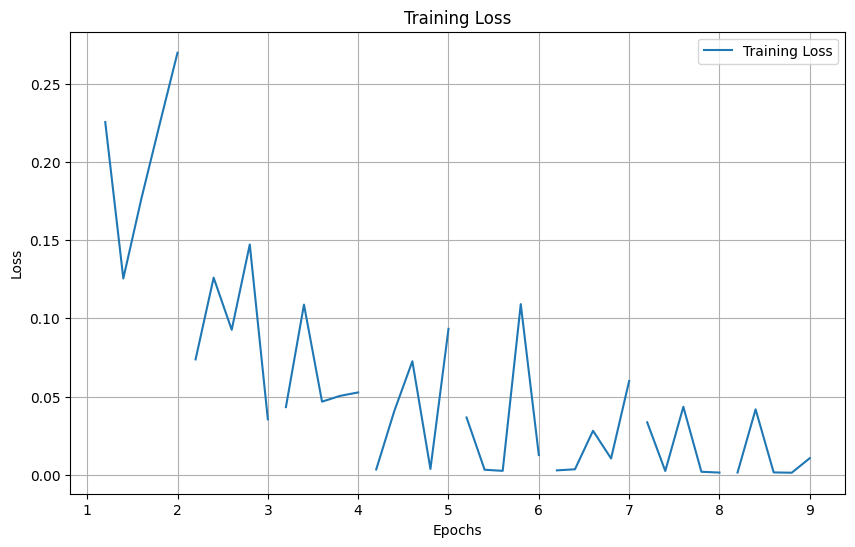

In [18]:
import matplotlib.pyplot as plt

history_df['epoch'] = history_df['epoch'] + 1

plt.figure(figsize=(10, 6))
plt.plot(history_df['epoch'], history_df['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()
plt.show()

In [20]:
def predict_text(text, model, tokenizer, device):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

    # Move the input tensors to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Ensure the model is on the correct device
    model.to(device)

    # Forward pass through the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    predicted_label = torch.argmax(probabilities, dim=1).item()

    sentiment = "Positive" if predicted_label == 1 else "Negative"

    return sentiment

# Determine if GPU is available, else use CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Example prediction
text_to_predict = "This is the best product I have ever bought!"
prediction = predict_text(text_to_predict, model, tokenizer, device)

print(f'Text: "{text_to_predict}"')
print(f'Predicted Sentiment: {prediction}')


Text: "This is the best product I have ever bought!"
Predicted Sentiment: Positive
